In [3]:
%reload_ext autoreload
%autoreload 2

from pathlib import Path
import sys
sys.path.append("..")

import json
from app.marker_tracker import CameraReading
from app.monitor_ble import StylusReading
from offline_playback import process_stroke, replay_data, merge_data, get_black_points, normalize_points, ProcessedStroke
import numpy as np
from PIL import Image
import pickle
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import seaborn as sns

%matplotlib inline

recording_timestamp = "20230905_162344"
savefig_kwargs = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0}

recording_dir = Path(f"../recordings") / recording_timestamp

scan_img = Image.open(recording_dir / "scan.jpg")
scan_dpi, _ = scan_img.info.get("dpi")
scan_x, scan_y = get_black_points(np.asarray(scan_img), scan_dpi)
scan_points = normalize_points(np.column_stack((scan_x, scan_y)))

def load_json_data(path, deserialize):
    with open(path, "r") as json_file:
        items: list = json.load(json_file)
    def parse(item: dict) -> tuple[float, StylusReading | CameraReading]:
        t = item["t"]
        reading = deserialize(item["data"])
        return t, reading
    return [parse(item) for item in items]

def load_and_process(stylus_data_fname, camera_data_fname, smoothing_length=14, imu_skip=1, camera_skip=1):
    stylus_data = load_json_data(recording_dir / stylus_data_fname, StylusReading.from_json)
    camera_data = load_json_data(recording_dir / camera_data_fname, CameraReading.from_json)
    recorded_data = merge_data(stylus_data[1::imu_skip], camera_data[::camera_skip])
    tip_pos_predicted, tip_pos_smoothed, pressure, tip_pos_cameraonly, pressure_cameraonly = replay_data(
        recorded_data,
        dt=imu_skip/120,
        smoothing_length=smoothing_length,
        camera_delay=4//imu_skip,
    )
    
    s0, s1 = 70, -70
    cameraonly = process_stroke(tip_pos_cameraonly, scan_points, pressure_cameraonly)
    tpp = process_stroke(tip_pos_predicted[s0:s1, :], scan_points, pressure[s0:s1])
    tps = process_stroke(tip_pos_smoothed[s0:s1, :], scan_points, pressure[s0:s1])
    return tpp, tps, cameraonly

def stroke_to_linecollection(stroke: ProcessedStroke, width, color):
    xy = stroke.position * 1000
    x, y = xy[:, 0], xy[:, 1]
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    lc = LineCollection(segments)
    pressure_clip = np.clip(stroke.pressure, 0, 1)
    lc.set_linewidth((pressure_clip**0.7) * width)
    # alpha = np.sqrt(pressure_clip)[:,np.newaxis]
    # color_vec = np.array(color,  dtype=float) * alpha + (1 - alpha)
    lc.set_alpha(pressure_clip**0.3)
    lc.set_color(color)
    lc.set_rasterized(True)
    lc.set_capstyle("round")
    proxy = Line2D([0, 1], [0, 1], color=color, lw=width, solid_capstyle="round")
    return lc, proxy

def plot_scan_points(scan_points, ax=None):
    ax: Axes = sns.scatterplot(
        x=scan_points[:, 0] * 1000,
        y=scan_points[:, 1] * 1000,
        color=(0.8, 0.8, 1),
        s=5,
        alpha=0.6,
        linewidth=0,
        ax=ax,
    )
    ax.set_aspect("equal")
    ax.set(xlabel="x (mm)", ylabel="y (mm)", ylim=(-48,34))
    ax.collections[0].set_rasterized(True)
    return ax

def plot_strokes(ax, tpp, tps):
    lc1, lc1_proxy = stroke_to_linecollection(tpp, 1.5, color=(0.9, 0.6, 0.6))
    ax.add_collection(lc1)
    lc2, lc2_proxy = stroke_to_linecollection(tps, 2.3, color=(0, 0, 0))
    ax.add_collection(lc2)
    ax.legend(
        [ax.collections[0], lc1_proxy, lc2_proxy],
        [
            "Scan",
            f"Predicted stroke, before smoothing (d={tpp.dist_mean*1000:0.3f}mm)",
            f"Estimated stroke, after smoothing (d={tps.dist_mean*1000:0.3f}mm)",
        ],
        loc="lower left",
        markerscale=3,
    )

def mini_plot(tpp, tps, noleftlabels=False, ax=None):
    ax = plot_scan_points(scan_points, ax=ax)
    plot_strokes(ax, tpp, tps)
    ax.set(ylim=(-62, 34))
    if noleftlabels:
        ax.set(ylabel=None, yticklabels=[])
    return ax

## Main sketch plot

sample_count: 4626
Resetting state, errors: 0.28229554569920684, 1.1355806651025042
Camera: 1.306ms +- 0.292
Stylus: 0.083ms +- 0.031


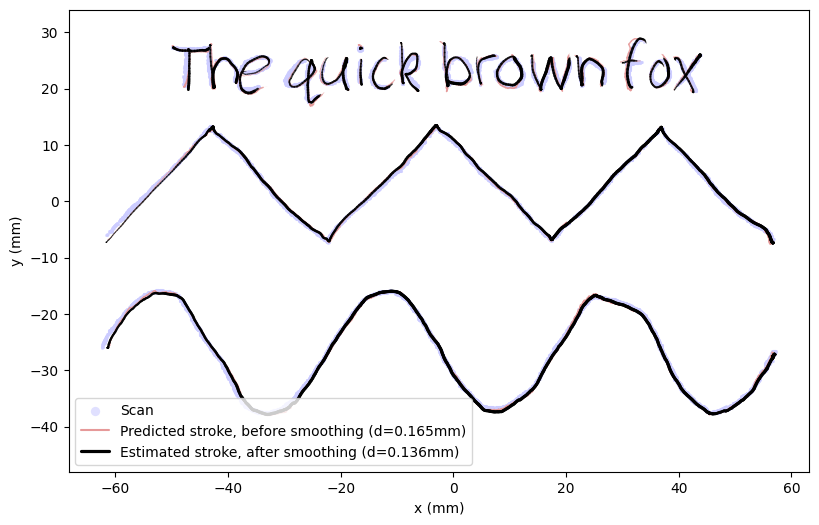

In [4]:
proposed_tpp, proposed_tps, proposed_cameraonly = load_and_process("stylus_data.json", "camera_data.json")
fig = plt.figure()
fig.set_size_inches(100,6)
ax = plot_scan_points(scan_points)
plot_strokes(ax, proposed_tpp, proposed_tps)

plt.savefig(recording_dir / "main-sketch-plot.pdf", **savefig_kwargs)

## Camera only

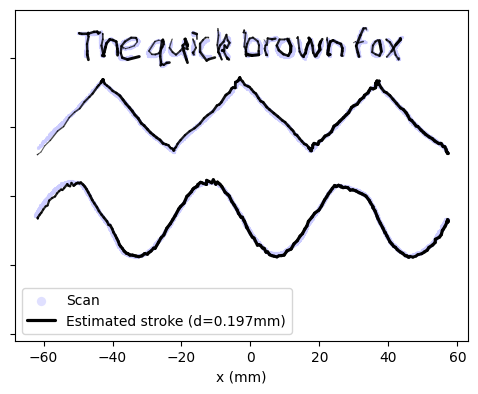

In [5]:
fig = plt.figure(figsize=(100,4.3))
ax = plot_scan_points(scan_points)
# _, _, proposed_cameraonly_10fps = load_and_process("stylus_data.pkl", "camera_data.pkl", camera_skip=3)
lc, lc_proxy = stroke_to_linecollection(proposed_cameraonly, 2.3, color=(0, 0, 0))
ax.add_collection(lc)
# plot_strokes(ax, tpp, tps)
ax.set(ylim=(-62, 34))
ax.set(ylabel=None, yticklabels=[])
ax.legend(
        [ax.collections[0], lc_proxy],
        [
            "Scan",
            f"Estimated stroke (d={proposed_cameraonly.dist_mean*1000:0.3f}mm)",
        ],
        loc="lower left",
        markerscale=3,
    )
plt.savefig(recording_dir / "cameraonly.pdf", **savefig_kwargs)

## Feature comparisons

In [6]:
nomarkercalib = load_and_process("stylus_data.json", "camera_data_nomarkercalib.json")
norsc = load_and_process("stylus_data.json", "camera_data_norsc.json")
epnp = load_and_process("stylus_data.json", "camera_data_epnp.json")
sqpnp = load_and_process("stylus_data.json", "camera_data_sqpnp.json")

sample_count: 4626
Resetting state, errors: 0.28199730820000646, 1.1353523357818023
Camera: 1.305ms +- 0.315
Stylus: 0.081ms +- 0.027
sample_count: 4626
Resetting state, errors: 0.2823078918282777, 1.1355098569871525
Camera: 1.349ms +- 1.259
Stylus: 0.082ms +- 0.025
sample_count: 4626
Resetting state, errors: 0.28238099756360474, 1.1361314314997604
Camera: 1.294ms +- 0.253
Stylus: 0.081ms +- 0.027
sample_count: 4626
Resetting state, errors: 0.28240014234383687, 1.1340665675574322
Camera: 1.288ms +- 0.177
Stylus: 0.080ms +- 0.023


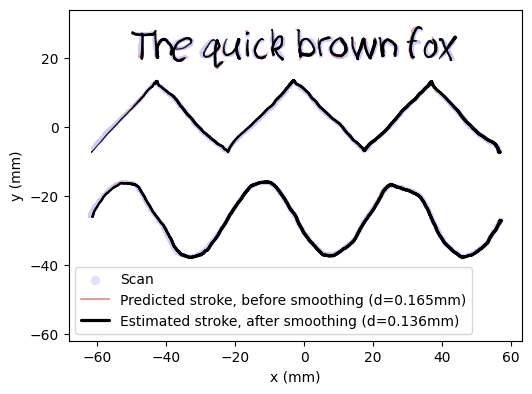

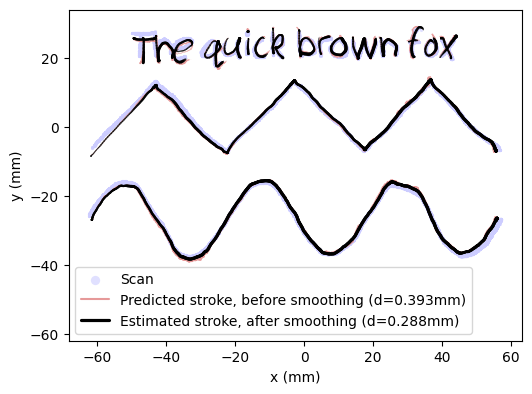

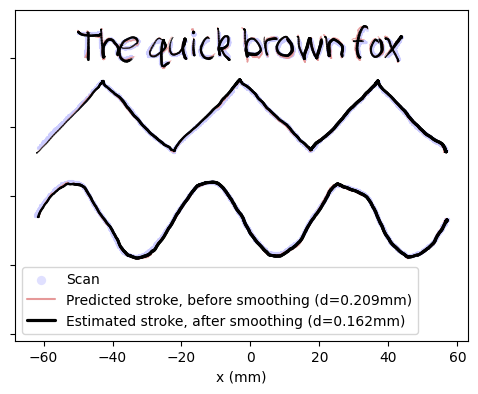

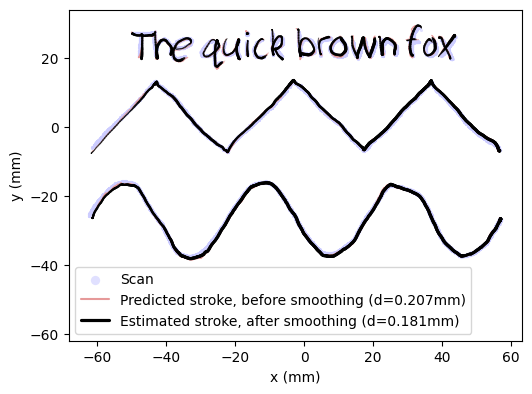

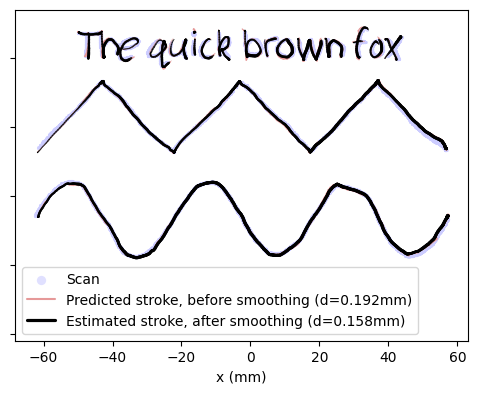

In [7]:
%matplotlib inline

fig = plt.figure(figsize=(100,4.3))
mini_plot(proposed_tpp, proposed_tps)
plt.savefig(recording_dir / "proposed.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(nomarkercalib[0], nomarkercalib[1])
plt.savefig(recording_dir / "nomarkercalib.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(norsc[0], norsc[1], noleftlabels=True)
plt.savefig(recording_dir / "norsc.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(epnp[0], epnp[1])
plt.savefig(recording_dir / "epnp.pdf", **savefig_kwargs)

fig = plt.figure(figsize=(100,4.3))
mini_plot(sqpnp[0], sqpnp[1], noleftlabels=True)
plt.savefig(recording_dir / "sqpnp.pdf", **savefig_kwargs)

## Smoothing

In [8]:
smoothing_lens = [0, 10, 50, 500]
smoothing_results = [
  load_and_process("stylus_data.json", "camera_data.json", smoothing_length=sl)
  for sl in smoothing_lens
]

sample_count: 4626
Resetting state, errors: 0.28229554569920684, 1.1355806651025042
Camera: 0.595ms +- 0.129
Stylus: 0.082ms +- 0.026
sample_count: 4626
Resetting state, errors: 0.28229554569920684, 1.1355806651025042
Camera: 1.166ms +- 0.268
Stylus: 0.085ms +- 0.050
sample_count: 4626
Resetting state, errors: 0.28229554569920684, 1.1355806651025042
Camera: 2.846ms +- 0.455
Stylus: 0.085ms +- 0.038
sample_count: 4626
Resetting state, errors: 0.28229554569920684, 1.1355806651025042
Camera: 19.017ms +- 3.661
Stylus: 0.094ms +- 0.039


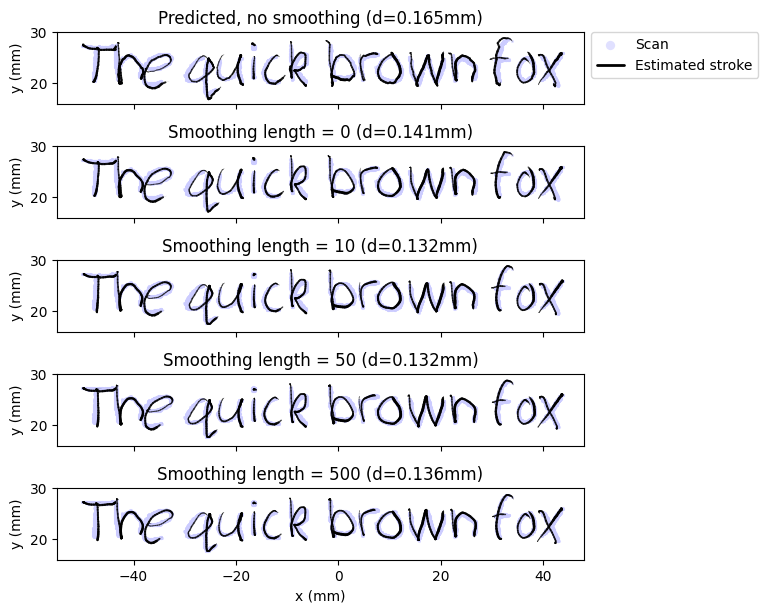

In [9]:
fig, axs = plt.subplots(len(smoothing_lens) + 1, 1, figsize=(6, 6), sharex=True)
fig.tight_layout()
lc_predicted, lc_proxy_predicted = stroke_to_linecollection(smoothing_results[0][0], 2, color=(0, 0, 0))
plot_scan_points(scan_points, ax=axs[0])
axs[0].add_collection(lc_predicted)
axs[0].set(xlim=(-55,48), ylim=(16, 30))
axs[0].set_title(f"Predicted, no smoothing (d={smoothing_results[0][0].dist_mean*1000:0.3f}mm)")
for i, sr in enumerate(smoothing_results):
    ax: Axes = axs[i+1]
    plot_scan_points(scan_points, ax=ax)
    # plot_strokes(ax, sr[0], sr[1], legend=False)
    lc, lc_proxy = stroke_to_linecollection(sr[1], 2, color=(0, 0, 0))
    ax.add_collection(lc)
    ax.set(xlim=(-55,48), ylim=(16, 30))
    ax.set_title(f"Smoothing length = {smoothing_lens[i]} (d={sr[1].dist_mean*1000:0.3f}mm)")

fig.legend(
    [axs[0].collections[0], lc_proxy_predicted],
    [
        "Scan",
        "Estimated stroke",
    ],
    # loc=(0.74, 0.89),
    loc='upper left',
    bbox_to_anchor=(1, 1.1),
    bbox_transform=axs[0].transAxes,
    markerscale=3,
)
plt.savefig(recording_dir / "smoothing-comparison.pdf", **savefig_kwargs)

## Camera frame rate

In [10]:
camera_skips = list(range(1, 11))
camera_skip_results = [
    load_and_process("stylus_data.json", "camera_data.json", camera_skip=cs, smoothing_length=10)
    for cs in camera_skips
]

sample_count: 4626
Resetting state, errors: 0.28229554569920684, 1.1355806651025042
Camera: 1.170ms +- 0.239
Stylus: 0.088ms +- 0.048
sample_count: 4626
Resetting state, errors: 0.28193729981361415, 1.1353730940130833
Camera: 1.163ms +- 0.197
Stylus: 0.080ms +- 0.033
sample_count: 4626
Resetting state, errors: 0.28017070257996557, 1.135465505880819
Camera: 1.223ms +- 0.396
Stylus: 0.084ms +- 0.041
sample_count: 4626
Resetting state, errors: 0.26717052123998114, 1.1358999451099914
Camera: 1.254ms +- 0.375
Stylus: 0.084ms +- 0.035
sample_count: 4626
Resetting state, errors: 0.257401834482191, 1.1363040328129639
Camera: 1.237ms +- 0.315
Stylus: 0.083ms +- 0.034
sample_count: 4626
Resetting state, errors: 0.2431754778546955, 1.1368455624283857
Camera: 1.214ms +- 0.217
Stylus: 0.084ms +- 0.043
sample_count: 4626
Resetting state, errors: 0.23385130101631718, 1.1367901149094661
Camera: 1.244ms +- 0.218
Stylus: 0.084ms +- 0.042
sample_count: 4626
Resetting state, errors: 0.22834010865666474, 1

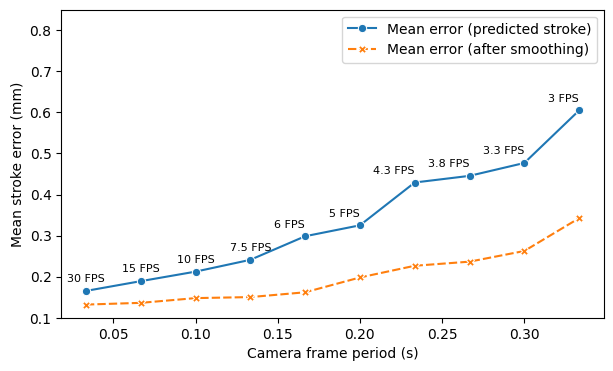

In [11]:
import pandas as pd
camera_skip_df = pd.DataFrame(
    {
        "camera_skip": camera_skips,
        "fps": [30/cs for cs in camera_skips],
        "period": [cs/30 for cs in camera_skips],
        "Mean error (predicted stroke)": [sr[0].dist_mean*1000 for sr in camera_skip_results],
        "Mean error (after smoothing)": [sr[1].dist_mean*1000 for sr in camera_skip_results],
    }
)

def plot_error_vs_camera_skip(camera_skip_df):
    fig = plt.figure(figsize=(7, 4))
    ax: Axes = sns.lineplot(
        x="period",
        y="value",
        style="variable",
        hue="variable",
        markers=True,
        data=pd.melt(camera_skip_df, ["camera_skip", "period", "fps"]),
        legend="brief",
    )

    ax.set(xlabel="Camera frame period (s)", ylabel="Mean stroke error (mm)", ylim=(0.1, 0.85))
    ax.get_legend().set_title(None)

    for row in camera_skip_df.itertuples():
        ax.annotate(
            f"{row.fps:.2g} FPS",
            (row.period, row[4]),
            xytext=(0, 5),
            textcoords="offset points",
            ha="right" if row.fps <= 6 else "center",
            va="bottom", # if row.fps >= 5 else "top",
            fontsize=8,
        )

plot_error_vs_camera_skip(camera_skip_df)
plt.savefig(recording_dir / "error-vs-camera-period.pdf", **savefig_kwargs)

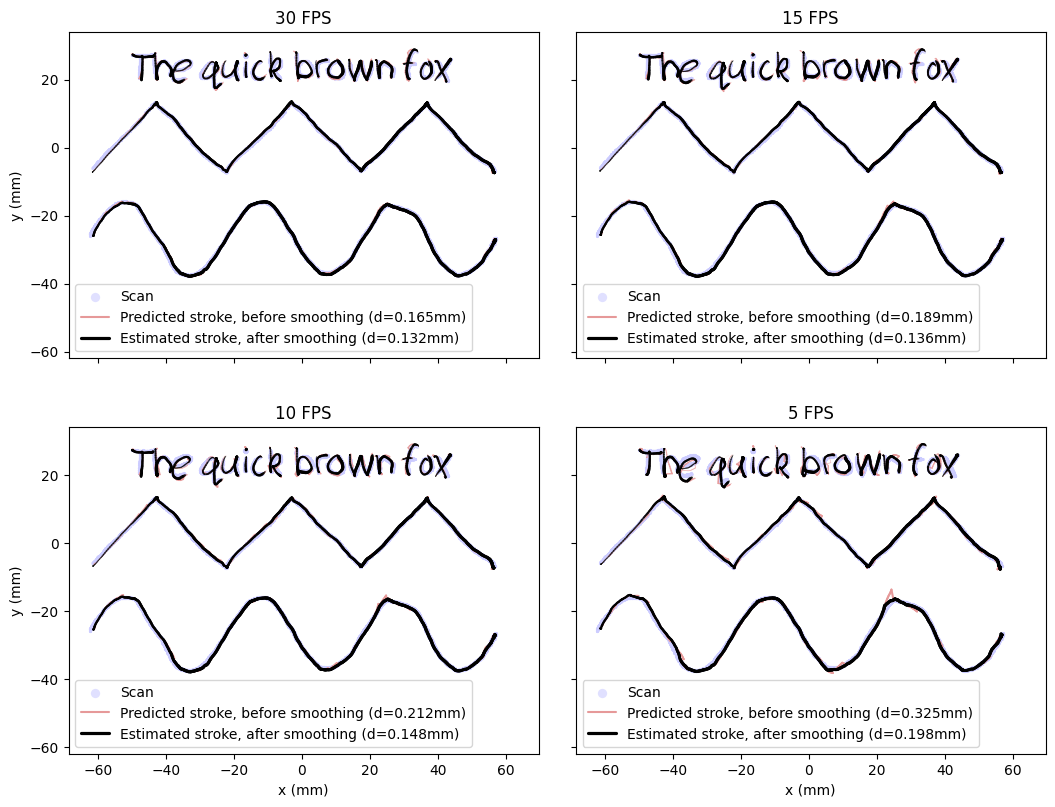

In [12]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.5, 8.5))
# plt.subplot()
fig.tight_layout()
fig.subplots_adjust(hspace=0)
for i in range(4):
    j = [0, 1, 2, 5][i]
    res_tpp, res_tps, _ = camera_skip_results[j]
    ax = mini_plot(res_tpp, res_tps, ax=axs.flat[i])
    ax.set_title(f"{30/camera_skips[j]:.0f} FPS")

def get_camera_points(stroke: ProcessedStroke):
    pos = stroke.position[stroke.pressure > 0.05,:]
    xy = pos[::120//30,:] * 1000
    x, y = xy[:, 0], xy[:, 1]
    return x, y
# ax.scatter(*get_camera_points(camera_skip_results[3][1]), s=6, marker='.', zorder=10)
plt.savefig(recording_dir / "camera-fps-comparison.pdf", **savefig_kwargs)